In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from wgomoku import GomokuTools as gt, SampleDataHelper

In [5]:
import numpy as np
import tensorflow as tf

In [75]:
def new_dataset(
    file_pattern, gamma,
    board_size=19, batch_size=256, num_epochs=1, buffer_size=500):
    
    sdh = SampleDataHelper(board_size)
    games = tf.data.experimental.make_csv_dataset(
        file_pattern = file_pattern,
        column_names=["game", "winner"],
        batch_size=1,
        num_epochs=num_epochs
    ) 
    def _generator(): 
        for batch in iter(games):
            game = batch['game'][0].numpy().decode('ascii')
            smp, lbl = sdh.from_string_with_bellmann(game, -1, gamma)
            zipped = zip(smp, lbl)
            for s_and_v in zipped:
                yield s_and_v
    
    inputs = tf.data.Dataset.from_generator(
        _generator, output_types=(tf.int32, tf.float32))
    
    inputs = inputs.shuffle(buffer_size).batch(batch_size)
    return inputs
    

In [76]:
inputs = new_dataset(file_pattern="*first3.csv", gamma=.9, batch_size=1)

In [77]:
smp, lbl = next(iter(inputs))

In [78]:
smp.shape, lbl.shape

(TensorShape([1, 21, 21, 2]), TensorShape([1]))

array([b'7'], dtype=object)

---
### The model

In [10]:
game="j10i9j9j11k10l11h10i10i11h9g8l13k12k9l14g9k11k13i13m13n13e9f9l10j8i6l8i8i7j7k6g10f11l9l12"

In [24]:
def disp(sample):
    if tf.is_tensor(sample):
        sample = sample.numpy()
    s = np.rollaxis(sample, -1, 0)
    return str(s[0]+2*s[1])

In [12]:
bw = np.zeros([5, 19+2, 19+2, 2], dtype=np.float16)
player = 0
stones = gt.string_to_stones(game)
stones = [(ord(s[0])-64, s[1]) for s in stones]
for (x,y) in stones:
    r,c = gt.b2m((x,y), 19)
    bw[0][r][c][player] = 1
    bw[1][r][c][player] = 1
    bw[2][r][c][player] = 1
    bw[3][r][c][player] = 1
    bw[4][r][c][player] = 1
    player = 1 - player


In [13]:
print(disp(bw[0]))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 2. 2. 2. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 2. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2. 1. 2. 1. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 1. 2. 2. 2. 1. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 2. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

In [7]:
class GomokuModelFactory:
    
    def __init__(self, board_size=19):
        self.board_size=board_size
    
    def res_block(self, inp, filters, activation='relu'):

        out1_3 = tf.keras.layers.Conv2D(kernel_size=3, filters=filters, 
                                  padding='same', activation=activation)(inp)
        out1_5 = tf.keras.layers.Conv2D(kernel_size=5, filters=filters,
                                  padding='same', activation=activation)(inp)
        out1 = tf.concat([out1_3, out1_5], axis=3)

        out2_3 = tf.keras.layers.Conv2D(kernel_size=3, filters=filters,
                                  padding='same', activation=activation)(out1)
        out2_5 = tf.keras.layers.Conv2D(kernel_size=5, filters=filters,
                                  padding='same', activation=activation)(out1)
        out2 = tf.concat([out2_3, out2_5], axis=3)

        out3_3 = tf.keras.layers.Conv2D(kernel_size=3, filters=filters, 
                                  padding='same', activation=activation)(out2)
        out3_5 = tf.keras.layers.Conv2D(kernel_size=5, filters=filters, 
                                  padding='same', activation=activation)(out2)
        out3 = tf.concat([out3_3, out3_5], axis=3)

        skip = tf.keras.layers.Conv2D(kernel_size=1, filters=2,
                                padding='same', activation=None)(inp)

        concat = tf.concat([skip, out3], axis=3)   

        bn = tf.keras.layers.BatchNormalization()(concat)

        return bn
    
    
    def create_value_model(self, name, num_blocks, num_filters, optimizer):

        inputs = tf.keras.Input(
            shape=[self.board_size+2,self.board_size+2,2], name="game_samples")
        
        labels = tf.keras.Input(
            shape=[1,1,1], name="value_labels")
        
        block = self.res_block(inputs, num_filters)
        for i in range(num_blocks):
            block = self.res_block(block, num_filters)
        
        out = tf.keras.layers.Conv2D(kernel_size=1, filters=1,
                       padding='same', activation='tanh')(block)
        
        flat = tf.keras.layers.Flatten()(out)
        hidden1 = tf.keras.layers.Dense(units=256)(flat)
        hidden2 = tf.keras.layers.Dense(units=64)(hidden1)
        value_head = tf.keras.layers.Dense(units=1, activation='tanh')(hidden2)
        #value_head = tf.keras.layers.MaxPool2D(pool_size=self.board_size)(out)        
        
        model = tf.keras.Model(inputs, value_head)

        model.compile(optimizer, loss='mean_squared_error')
        
        return model


In [42]:
factory = GomokuModelFactory(board_size=19)

In [43]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

In [52]:
value_model = factory.create_value_model("Value_Net", 2, 32, optimizer)

In [52]:
value_model.predict(bw)

array([[0.00153481],
       [0.00153481],
       [0.00153481],
       [0.00153481],
       [0.00153481]], dtype=float32)

In [53]:
inputs = new_dataset(board_size=19, batch_size=512, num_epochs=100, 
                     buffer_size=500, file_pattern = "*first3.csv", gamma=0.5)

In [54]:
value_model.fit(inputs)

141/141 [==============================] - 32s 226ms/step - loss: 0.4758


In [86]:
export_path = 'ValueNet_1.0.hd5'

In [30]:
#tf.keras.experimental.export_saved_model(
#    model=value_model, saved_model_path='./ValueNet/')

In [ ]:
value_model.

In [35]:
inputs = tf.data.Dataset.from_generator(generator, output_types=(tf.int32, tf.float32))

In [17]:
from wgomoku import HeuristicGomokuPolicy, GomokuBoard, Heuristics

In [18]:
heuristics = Heuristics(kappa=3.0)

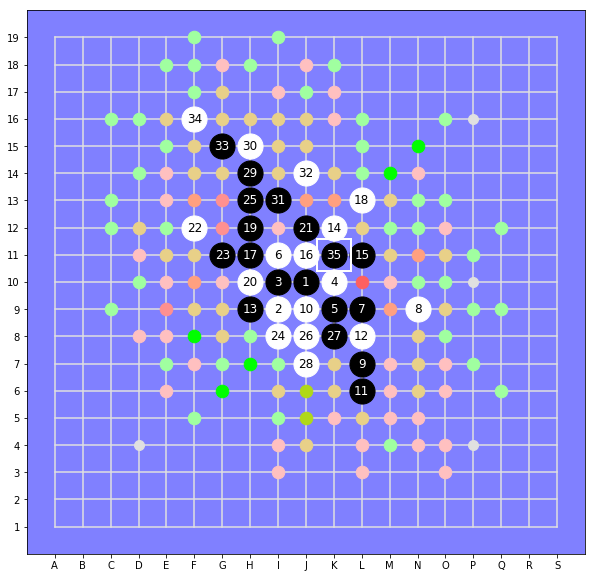

In [19]:
game="j10i9i10k10k9i11l9n9l7j9l6l8h9k12l11j11h11l13h12h10j12f12g11i8h13j8k8j7h14h15i13j14g15f16k11"
stones=gt.string_to_stones(game)
board = GomokuBoard(N=19, stones=stones, disp_width=10, heuristics=heuristics)
board.display('current')

In [20]:
sdh = SampleDataHelper(19)

In [39]:
game="j10i9i10k10k9i11l9n9l7j9l6l8h9k12l11j11h11l13h12h10j12f12g11i8h13j8k8j7h14h15i13"
coords = sdh.padded_coords(game+"")

In [40]:
template = sdh.template()
to_move=1
for move in coords:
    template[move[0], move[1], to_move] = 1
    to_move = 1 - to_move

In [41]:
value_model.predict(template.reshape(1,21,21,2))

array([[0.18541837]], dtype=float32)

In [50]:
inputs = new_dataset(board_size=19, batch_size=512, num_epochs=1, buffer_size=500)

In [58]:
iterator = iter(inputs)

In [72]:
smp = next(iterator)[0][0]
print(disp(smp))

[[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 2 1 1 1 1 2 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 1 2 1 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 2 0 2 1 2 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
